In [1]:
from gtda.homology import EuclideanCechPersistence,VietorisRipsPersistence
from gtda.diagrams import PersistenceImage
from gtda.pipeline import Pipeline
from gtda.diagrams import Filtering

In [2]:
import tensorflow as tf
import gudhi as gd
import numpy as np
import matplotlib.pyplot as plt
import utils
import scipy.spatial as spatial
import json
from rich import print
from random import choice, sample
from tqdm.notebook import tqdm
from rdkit import Chem
from rdkit.Chem import Descriptors
from gc import collect

with open("data/drugbank.json", mode = "r") as drugbank:
    db = json.load(drugbank)

%matplotlib inline

# Transform data to point clouds

In [3]:
spectra = dict()

mol_indices = list(sample(list(range(len(db))), 9701))
mol_strings = np.asarray(list(db.keys()))[ mol_indices ]

for m in tqdm(mol_strings):
    energies = [
        np.asarray([ utils.split_fpn(x) for x in db[m]["energy0"]["mz"] ]),
        np.asarray([ utils.split_fpn(x) for x in db[m]["energy1"]["mz"] ]),
        np.asarray([ utils.split_fpn(x) for x in db[m]["energy2"]["mz"] ])
    ]
    for i,energy in enumerate(energies):
        energies[i][:,0] = np.log(energy[:,0])/np.log(6000)
        
    spectra[m] = tuple(energies)

mol_strings = list(spectra.keys())
del mol_indices
del db
collect()

  0%|          | 0/9701 [00:00<?, ?it/s]

22

# Inspect data

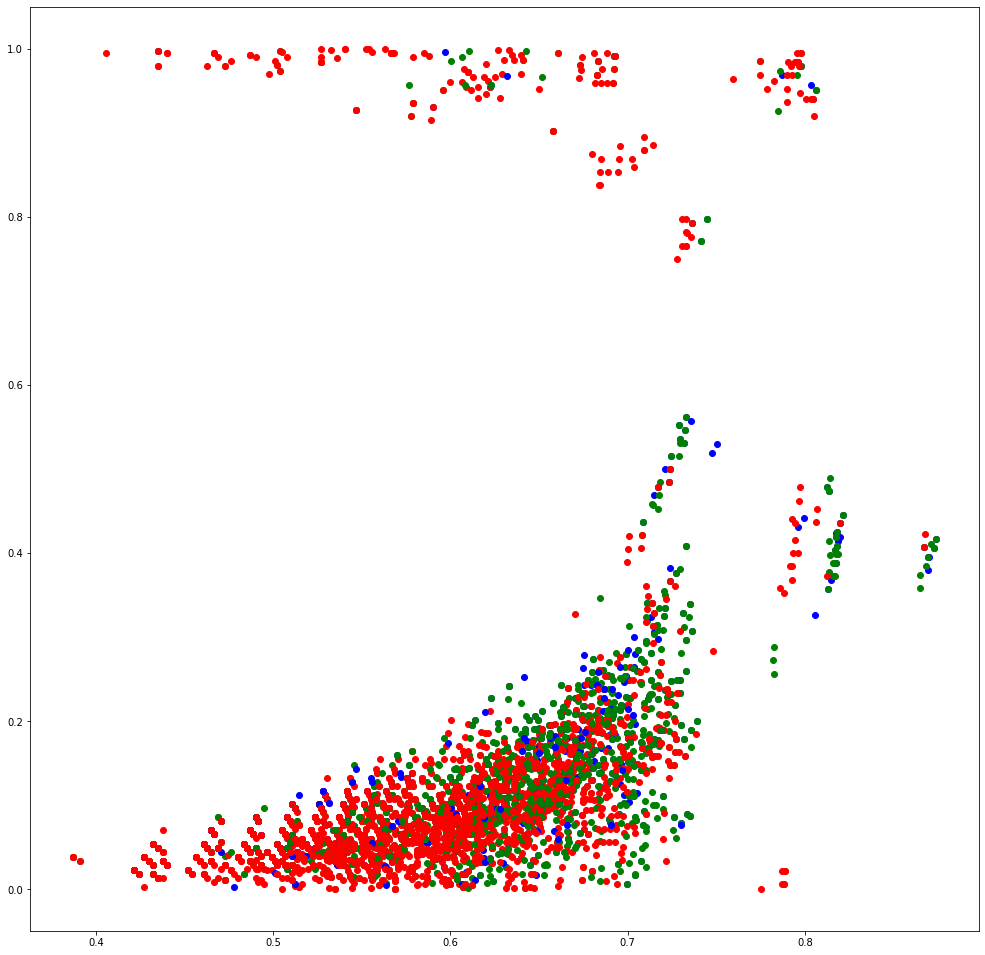

In [4]:
fig = plt.figure(figsize=(17,17))
ax = fig.add_subplot()
for mol_s in sample(mol_strings, min(len(mol_strings), 100) ):
    (X0,X1,X2) = spectra[ mol_s ]
    ax.scatter(X0[:,0],X0[:,1], color = "blue")
    ax.scatter(X1[:,0],X1[:,1], color = "green")
    ax.scatter(X2[:,0],X2[:,1], color = "red")

# Crossval split

In [5]:
train_mols = sample(mol_strings, int(np.ceil(len(mol_strings)*0.8)) )
test_mols = list(set(mol_strings) - set(train_mols))

train_spectra = { m : spectra[m] for m in train_mols }
test_spectra = { m : spectra[m] for m in test_mols }

assert set(train_spectra.keys()).intersection(set(test_spectra.keys())) == set()
print('# train_mols: ',len(train_mols), '\t # test mols: ', len(test_mols))

# train_mols:  7761      # test mols:  1940

# Compute Čech persistence

In [6]:
def compute_cech_persistence(spectra):
    pipeline = Pipeline([
        ('diagram', VietorisRipsPersistence(
            homology_dimensions = [0,1,2],
            max_edge_length = np.sqrt(2),
            n_jobs = 3,
        )),
        ('filtering', Filtering()),
        ('image', PersistenceImage(n_bins = 50, n_jobs = 3)),
    ])
    # dictionary of 3-tuples of point clouds
    molecules = list(spectra.keys())
    x0 = [ X[0] for X in spectra.values() ]
    x1 = [ X[1] for X in spectra.values() ]
    x2 = [ X[2] for X in spectra.values() ]
    data = (
        pipeline.fit_transform(x0),
        pipeline.fit_transform(x1),
        pipeline.fit_transform(x2),
    )
    data = np.concatenate(data, axis = 1)
    return molecules, data

train_molecules, train_data = compute_cech_persistence(train_spectra)
test_molecules, test_data = compute_cech_persistence(test_spectra)

In [7]:
import pickle

In [8]:
save_dict = dict()
save_dict["train_molecules"] = train_molecules
save_dict["train_data"] = train_data
save_dict["test_molecules"] = test_molecules
save_dict["test_data"] = test_data

with open('9701_vr_persistence_images_012_50x50.pickle', 'wb') as handle:
    pickle.dump(save_dict, handle)